In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'used-car-price-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3742543%2F6478229%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240704%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240704T024637Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da288c623c7a12558d663ea8f756df81df41d794084a3af81369d72600055ce0fa4c3739e11c6bfd7ab253ffcf6e451f6facffb0e9004b2f1033c13a2904a58c3bde6d62938ab628accdd298fe851a617e9c81c1ffcbb9ae026cba5e0019161bd300ba27e2033dda27c24545c24a83f2bd5a067878f860d65599f4f84d942cad7cd95d05295999c9bb9ae2ad13441c43c5c7d7cce257cf99b6cb546a30e977696eb5a6c0b819d9c585b710c945349b548081f0a6a03edd82cf744453b55c4afbcf7cb69bda0433293b751e04cdf96ae2336359308fc6700e231f403700f6ef8d5f6aa6f5b0f8b9ce88846e569b81308e0459d54752b59d82f70900a960b692255'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 112006 bytes downloaded
Downloaded and uncompressed: used-car-price-prediction-dataset
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
path = '/kaggle/input/used-car-price-prediction-dataset/used_cars.csv'
df = pd.read_csv(path)
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [ ]:
df.to_csv('used_cars.csv', index = False)

In [ ]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [ ]:
df.dtypes

brand           object
model           object
model_year       int64
milage          object
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price           object
dtype: object

In [ ]:
df.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

In [ ]:
df.drop('model', axis = 1, inplace = True)

In [ ]:
df['milage'] = df['milage'].str.replace(',', '').str.replace(' mi', '').astype(float)
df['milage']

0       51000.0
1       34742.0
2       22372.0
3       88900.0
4        9835.0
         ...   
4004      714.0
4005    10900.0
4006     2116.0
4007    33000.0
4008    43000.0
Name: milage, Length: 4009, dtype: float64

In [ ]:
df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)
df['price']

0        10300.0
1        38005.0
2        54598.0
3        15500.0
4        34999.0
          ...   
4004    349950.0
4005     53900.0
4006     90998.0
4007     62999.0
4008     40000.0
Name: price, Length: 4009, dtype: float64

In [ ]:
df.head()

,brand,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.0
1,Hyundai,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.0
2,Lexus,2022,22372.0,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,54598.0
3,INFINITI,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500.0
4,Audi,2021,9835.0,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,34999.0


In [ ]:
df['fuel_type'].fillna(df['fuel_type'].value_counts().idxmax(), inplace = True)

In [ ]:
df['fuel_type'].value_counts()

fuel_type
Gasoline          3479
Hybrid             194
E85 Flex Fuel      139
Diesel             116
–                   45
Plug-In Hybrid      34
not supported        2
Name: count, dtype: int64

In [ ]:
df['fuel_type'].replace('–', 'Electric', inplace = True)
df['fuel_type'].replace('not supported', 'Electric', inplace = True)

In [ ]:
df.dropna(subset = ['clean_title', 'accident'], axis = 0, inplace = True)

In [ ]:
df.head()

,brand,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.0
1,Hyundai,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.0
3,INFINITI,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500.0
6,Audi,2017,84000.0,Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,None reported,Yes,31000.0
7,BMW,2001,242000.0,Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,None reported,Yes,7300.0


In [ ]:
df.shape

(3413, 11)

In [ ]:
import re

def extract_engine_attributes(engine_str):
    horsepower = re.search(r'(\d+\.\d+)HP|\d+\.\d+', engine_str)
    displacement = re.search(r'(\d+\.\d+L|\d+\.\d+ Liter)', engine_str)
    return horsepower.group(1) if horsepower else '',\
           displacement.group(1) if displacement else ''

df[['Horsepower', 'Engine_Displacement']] = df['engine'].apply(extract_engine_attributes).apply(pd.Series)

In [ ]:
df.head()

,brand,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Engine_Displacement
0,Ford,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.0,300.0,3.7L
1,Hyundai,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.0,None,3.8L
3,INFINITI,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500.0,354.0,3.5L
6,Audi,2017,84000.0,Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,None reported,Yes,31000.0,292.0,2.0L
7,BMW,2001,242000.0,Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,None reported,Yes,7300.0,282.0,4.4L


In [ ]:
df['Horsepower'].isnull().sum()

242

In [ ]:
df['Horsepower'] = pd.to_numeric(df['Horsepower'], errors = 'coerce')
df['Horsepower'].dtype

dtype('float64')

In [ ]:
df['Horsepower'].fillna(df['Horsepower'].mean(), inplace = True)
df['Horsepower'].isnull().sum()

0

In [ ]:
df['Engine_Displacement'] = df['Engine_Displacement'].str.replace('L', '')

In [ ]:
df['Engine_Displacement'] = pd.to_numeric(df['Engine_Displacement'], errors = 'coerce')

In [ ]:
df['Engine_Displacement'].fillna(df['Engine_Displacement'].mean(), inplace = True)
df['Engine_Displacement'].isnull().sum()

0

In [ ]:
df.drop('engine', axis = 1, inplace = True)

In [ ]:
df['model_year'].max()

2024

In [ ]:
df['age'] = 2024 - df['model_year']

In [ ]:
df.drop('model_year', axis = 1, inplace = True)

In [ ]:
df.head()

,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Engine_Displacement,age
0,Ford,51000.0,E85 Flex Fuel,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.0,300.000000,3.7,11
1,Hyundai,34742.0,Gasoline,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.0,331.445122,3.8,3
3,INFINITI,88900.0,Hybrid,7-Speed A/T,Black,Black,None reported,Yes,15500.0,354.000000,3.5,9
6,Audi,84000.0,Gasoline,6-Speed A/T,Blue,Black,None reported,Yes,31000.0,292.000000,2.0,7
7,BMW,242000.0,Gasoline,A/T,Green,Green,None reported,Yes,7300.0,282.000000,4.4,23


(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 [Text(-50000.0, 0, '−50000'),
  Text(0.0, 0, '0'),
  Text(50000.0, 0, '50000'),
  Text(100000.0, 0, '100000'),
  Text(150000.0, 0, '150000'),
  Text(200000.0, 0, '200000'),
  Text(250000.0, 0, '250000'),
  Text(300000.0, 0, '300000'),
  Text(350000.0, 0, '350000'),
  Text(400000.0, 0, '400000'),
  Text(450000.0, 0, '450000')])

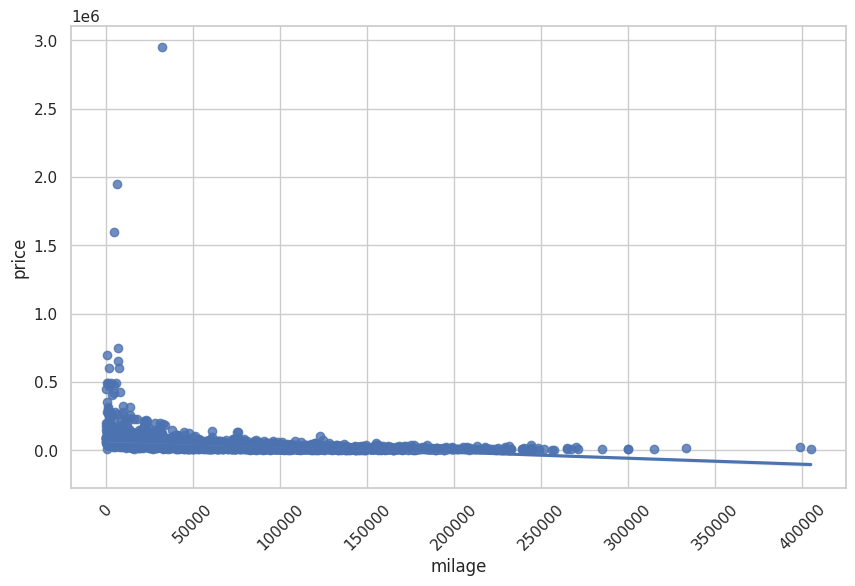

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.regplot(x = 'milage', y = 'price', data =df)
plt.xticks(rotation=45)

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60')])

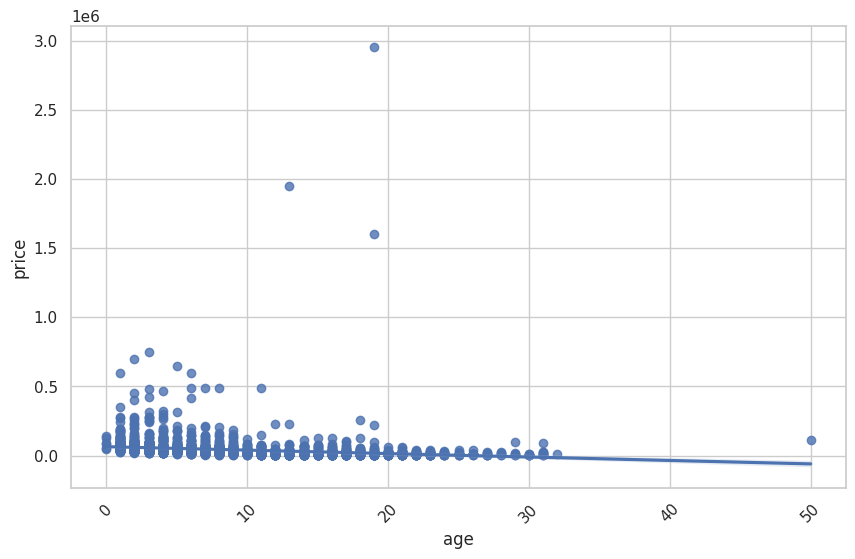

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.regplot(x = 'age', y = 'price', data =df)
plt.xticks(rotation=45)

In [ ]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
import category_encoders as ce
encoder = ce.TargetEncoder(cols=['fuel_type'])
df['fuel_type_target'] = encoder.fit_transform(df['fuel_type'], df['price'])
df.head()

,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Engine_Displacement,age,fuel_type_target
0,Ford,51000.0,E85 Flex Fuel,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.0,300.000000,3.7,11,22119.767316
1,Hyundai,34742.0,Gasoline,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.0,331.445122,3.8,3,42161.433930
3,INFINITI,88900.0,Hybrid,7-Speed A/T,Black,Black,None reported,Yes,15500.0,354.000000,3.5,9,49021.296982
6,Audi,84000.0,Gasoline,6-Speed A/T,Blue,Black,None reported,Yes,31000.0,292.000000,2.0,7,42161.433930
7,BMW,242000.0,Gasoline,A/T,Green,Green,None reported,Yes,7300.0,282.000000,4.4,23,42161.433930


In [ ]:
encoder = ce.TargetEncoder(cols=['transmission'])
df['transmission_target'] = encoder.fit_transform(df['transmission'], df['price'])

In [ ]:
encoder = ce.TargetEncoder(cols=['brand'])
df['brand_target'] = encoder.fit_transform(df['brand'], df['price'])

In [ ]:
df.drop(['ext_col', 'int_col'], axis = 1, inplace = True)

In [ ]:
df['fuel_type_target'].corr(df['price'])

0.05254335528478573

In [ ]:
df['transmission_target'].corr(df['price'])

0.2706528051936001

In [ ]:
df['brand_target'].corr(df['price'])

0.44372426552211525

In [ ]:
df['age'].corr(df['price'])

-0.187980917862779

In [ ]:
df['Engine_Displacement'].corr(df['price'])

0.1624588311616872

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
x = df[['brand_target']]
y = df[['price']]
lm.fit(x,y)

LinearRegression()

In [ ]:
yhat = lm.predict(x)
yhat[0:5]

array([[32164.8566153 ],
       [ 3059.27680813],
       [10074.48442978],
       [32640.44325277],
       [38509.83981333]])

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df['price'], yhat)
mse

5329323342.269223

In [ ]:
from sklearn.metrics import r2_score
r2_score(df['price'], yhat)

0.19689122381314061

In [ ]:
df.head()

,brand,milage,fuel_type,transmission,accident,clean_title,price,Horsepower,Engine_Displacement,age,fuel_type_target,transmission_target,brand_target
0,Ford,51000.0,E85 Flex Fuel,6-Speed A/T,At least 1 accident or damage reported,Yes,10300.0,300.000000,3.7,11,22119.767316,25252.872881,34172.233618
1,Hyundai,34742.0,Gasoline,8-Speed Automatic,At least 1 accident or damage reported,Yes,38005.0,331.445122,3.8,3,42161.433930,93201.161561,18714.294429
3,INFINITI,88900.0,Hybrid,7-Speed A/T,None reported,Yes,15500.0,354.000000,3.5,9,49021.296982,47571.348178,22440.062943
6,Audi,84000.0,Gasoline,6-Speed A/T,None reported,Yes,31000.0,292.000000,2.0,7,42161.433930,25252.872881,34424.817122
7,BMW,242000.0,Gasoline,A/T,None reported,Yes,7300.0,282.000000,4.4,23,42161.433930,31200.125123,37542.046729


In [ ]:
row_1 = df[['brand_target']].iloc[[0]]
row_1

,brand_target
0,34172.233618


In [ ]:
prediction = lm.predict(row_1)
prediction

array([[32164.8566153]])

In [ ]:
Z = df[['brand_target', 'fuel_type_target', 'transmission_target', 'age', 'milage', 'Horsepower', 'Engine_Displacement']]
Z.head()

,brand_target,fuel_type_target,transmission_target,age,milage,Horsepower,Engine_Displacement
0,34172.233618,22119.767316,25252.872881,11,51000.0,300.000000,3.7
1,18714.294429,42161.433930,93201.161561,3,34742.0,331.445122,3.8
3,22440.062943,49021.296982,47571.348178,9,88900.0,354.000000,3.5
6,34424.817122,42161.433930,25252.872881,7,84000.0,292.000000,2.0
7,37542.046729,42161.433930,31200.125123,23,242000.0,282.000000,4.4


In [ ]:
lm.fit(Z, y)

LinearRegression()

In [ ]:
yhat2 = lm.predict(Z)
yhat2[0:5]

array([[20124.09989684],
       [51312.47618525],
       [17509.81400672],
       [12541.78681157],
       [-7322.07239928]])

In [ ]:
lm.score(Z, y)

0.25986069466996176

In [ ]:
mse = mean_squared_error(df['price'], yhat2)
mse

4911466283.751016

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(Z, y, test_size = 0.2, random_state = 0)

In [ ]:
lm.fit(x_train, y_train)

LinearRegression()

In [ ]:
y_test.head()

,price
2331,19500.0
3846,38500.0
1239,10600.0
290,24500.0
1528,8750.0


In [ ]:
yhat3 = lm.predict(x_test)
yhat3[0:5]

array([[24111.21032689],
       [71581.38576974],
       [17048.58208033],
       [16602.43433383],
       [13488.2506601 ]])

In [ ]:
lm.score(x_test, y_test)

0.3862967929249308

In [ ]:
r2_score(y_test, yhat3)

0.3862967929249308

<ipython-input-72-7bdf83c4f985>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, hist=False, color="r", label="Actual Value")
<ipython-input-72-7bdf83c4f985>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(yhat3, hist=False, color="b", label="Fitted Values")


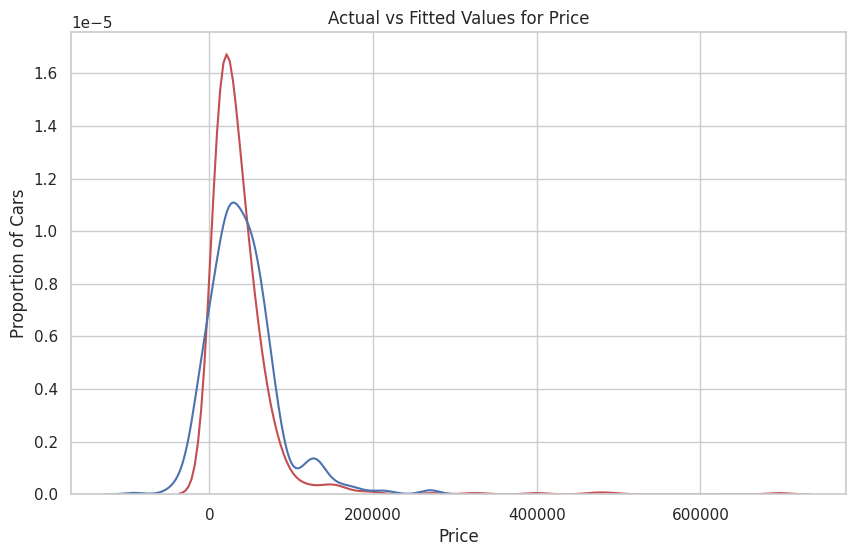

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(yhat3, hist=False, color="b", label="Fitted Values")
plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Cars')
plt.show()
plt.close()

In [ ]:
lm.predict(x_test.iloc[[0]])

array([[24111.21032689]])

In [ ]:
y_test.iloc[0]

price    19500.0
Name: 2331, dtype: float64

In [ ]:
x_test.iloc[0]

brand_target           29642.520136
fuel_type_target       42161.433930
transmission_target    31200.125123
age                        6.000000
milage                 29000.000000
Horsepower               166.000000
Engine_Displacement        2.400000
Name: 2331, dtype: float64

In [ ]:
from joblib import dump, load

dump(lm, 'linear_regression_model.joblib')

['linear_regression_model.joblib']

In [ ]:
from google.colab import files

files.download('linear_regression_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.head()

,brand,milage,fuel_type,transmission,accident,clean_title,price,Horsepower,Engine_Displacement,age,fuel_type_target,transmission_target,brand_target
0,Ford,51000.0,E85 Flex Fuel,6-Speed A/T,At least 1 accident or damage reported,Yes,10300.0,300.000000,3.7,11,22119.767316,25252.872881,34172.233618
1,Hyundai,34742.0,Gasoline,8-Speed Automatic,At least 1 accident or damage reported,Yes,38005.0,331.445122,3.8,3,42161.433930,93201.161561,18714.294429
3,INFINITI,88900.0,Hybrid,7-Speed A/T,None reported,Yes,15500.0,354.000000,3.5,9,49021.296982,47571.348178,22440.062943
6,Audi,84000.0,Gasoline,6-Speed A/T,None reported,Yes,31000.0,292.000000,2.0,7,42161.433930,25252.872881,34424.817122
7,BMW,242000.0,Gasoline,A/T,None reported,Yes,7300.0,282.000000,4.4,23,42161.433930,31200.125123,37542.046729


In [ ]:
df['brand'].unique()

array(['Ford', 'Hyundai', 'INFINITI', 'Audi', 'BMW', 'Lexus', 'Tesla',
       'Aston', 'Toyota', 'Lincoln', 'Land', 'Mercedes-Benz', 'Dodge',
       'Nissan', 'Jaguar', 'Chevrolet', 'Kia', 'Jeep', 'Bentley', 'Lucid',
       'MINI', 'Porsche', 'Hummer', 'Chrysler', 'Acura', 'Volvo',
       'Cadillac', 'Maserati', 'Genesis', 'Volkswagen', 'Rivian', 'GMC',
       'RAM', 'Subaru', 'Alfa', 'Ferrari', 'Scion', 'Mitsubishi', 'Mazda',
       'Saturn', 'Honda', 'Bugatti', 'Lamborghini', 'Rolls-Royce',
       'McLaren', 'Buick', 'Lotus', 'Pontiac', 'FIAT', 'Karma', 'Saab',
       'Mercury', 'Plymouth', 'smart', 'Maybach', 'Suzuki'], dtype=object)

In [ ]:
df['fuel_type'].unique()

array(['E85 Flex Fuel', 'Gasoline', 'Hybrid', 'Diesel', 'Plug-In Hybrid',
       'Electric'], dtype=object)

In [ ]:
df['fuel_type'].value_counts()

fuel_type
Gasoline          2959
Hybrid             145
E85 Flex Fuel      128
Diesel             102
Electric            46
Plug-In Hybrid      33
Name: count, dtype: int64

In [ ]:
df['transmission'].value_counts()

transmission
A/T                                  1015
8-Speed A/T                           391
Transmission w/Dual Shift Mode        389
6-Speed A/T                           354
6-Speed M/T                           238
7-Speed A/T                           201
10-Speed A/T                          115
5-Speed A/T                            84
9-Speed A/T                            73
4-Speed A/T                            72
1-Speed A/T                            63
CVT Transmission                       62
8-Speed Automatic                      62
5-Speed M/T                            57
6-Speed Automatic                      39
M/T                                    38
10-Speed Automatic                     35
Automatic                              30
9-Speed Automatic                      26
Automatic CVT                          11
7-Speed M/T                             9
7-Speed Automatic with Auto-Shift       8
Transmission Overdrive Switch           7
8-Speed Automatic wit

In [ ]:
df['transmission'].unique()

array(['6-Speed A/T', '8-Speed Automatic', '7-Speed A/T', 'A/T',
       '8-Speed A/T', 'Transmission w/Dual Shift Mode',
       '9-Speed Automatic', '6-Speed M/T', 'Automatic', '10-Speed A/T',
       '9-Speed A/T', '5-Speed A/T', '1-Speed A/T',
       '6-Speed Automatic with Auto-Shift', 'M/T', 'CVT Transmission',
       '4-Speed A/T', '6-Speed Automatic', '4-Speed Automatic',
       'Automatic CVT', '8-Speed Automatic with Auto-Shift',
       '7-Speed Automatic with Auto-Shift', '5-Speed M/T',
       '7-Speed Manual', '10-Speed Automatic', '1-Speed Automatic',
       '6-Speed Manual', 'Transmission Overdrive Switch',
       '7-Speed Automatic', '–', '5-Speed Automatic', '7-Speed',
       '7-Speed M/T', '7-Speed DCT Automatic', '2-Speed A/T'],
      dtype=object)